## Spatial Regridding and masking data cubes 
### A DeepESDL example notebook 

This notebook demonstrates how to access two different data sets, transform one of them so that both share the same spatial grid, and mask one dataset by applying a condition from the other dataset. 


Please, also refer to the [DeepESDL documentation](https://earthsystemdatalab.net/guide/jupyterlab) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2025

-----------------

**This notebook runs with the python environment `users-deepesdl-xcube-1.9.1`, please checkout the documentation for [help on changing the environment](https://earthsystemdatalab.net/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kernel).**

In [1]:
import datetime

import numpy as np
import pandas as pd
import shapely.geometry
import xarray as xr
from IPython.display import JSON
from xcube.core.gridmapping import GridMapping
from xcube.core.maskset import MaskSet
from xcube.core.resampling import resample_in_space
from xcube.core.store import new_data_store

Open CCI store 

In [2]:
cci_store = new_data_store("ccizarr")

Open an s3 store and list all datasets, here we chose the deep-esdl-public s3 bucket.

In [3]:
root = "deep-esdl-public"

In [4]:
s3_store = new_data_store("s3", 
                          root=root, 
                          storage_options=dict(
                              anon=True)
                         )

In [5]:
list(s3_store.get_data_ids())

['LC-1x2025x2025-2.0.0.levels',
 'LC-1x2160x2160-1.0.0.levels',
 'SMOS-L2C-OS-20230101-20231231-1W-res0-1x1000x1000.levels',
 'SMOS-L2C-OS-20230101-20231231-1W-res0-53x120x120.zarr',
 'SMOS-L2C-OS-20230101-20231231-1W-res0.zarr',
 'SMOS-L2C-SM-20230101-20231231-1W-res0-1x1000x1000.levels',
 'SMOS-L2C-SM-20230101-20231231-1W-res0-53x120x120.zarr',
 'SMOS-L2C-SM-20230101-20231231-1W-res0.zarr',
 'SMOS-freezethaw-1x720x720-1.0.1.zarr',
 'SMOS-freezethaw-4267x10x10-1.0.1.zarr',
 'SeasFireCube-8D-0.25deg-1x720x1440-3.0.0.zarr',
 'SeasFireCube-8D-0.25deg-966x180x360-3.0.0.zarr',
 'SeasFireCube_v3.zarr',
 'black-sea-1x1024x1024.levels',
 'black-sea-256x128x128.zarr',
 'esa-cci-permafrost-1x1151x1641-0.0.2.levels',
 'esa-cci-permafrost-1x1151x1641-1.0.0.zarr',
 'esdc-8d-0.25deg-1x720x1440-3.0.1.zarr',
 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr',
 'extrAIM-merged-cube-1x86x179.zarr',
 'hydrology-1D-0.009deg-100x60x60-3.0.2.zarr',
 'hydrology-1D-0.009deg-1418x70x76-2.0.0.zarr',
 'hydrology-1D-0.00

Open Land Cover (LC) dataset from s3 bucket, which is saved as a multilevel dataset:

In [6]:
ml_LC = s3_store.open_data("LC-1x2160x2160-1.0.0.levels", decode_cf=True)

Lets open level 0, which is the base level and therefore has the highest resolution:

In [7]:
LC = ml_LC.get_dataset(0)

Now let's search for soil datasets provided via the xcube cci store: 

In [8]:
cci_store.list_data_ids()

['ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2018-fv2.0.zarr',
 'ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2020-fv4.0.zarr',
 'ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr',
 'ESACCI-GHG-L2-CO2-OCO-2-FOCAL-2014-2021-v10.zarr',
 'ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr',
 'ESACCI-ICESHEETS_Antarctica_GMB-2002-2016-v1.1.zarr',
 'ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr',
 'ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2018-fv1.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2020-fv2.0.zarr',
 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_DAY-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_NIGHT-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_DAY-1995-2020-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_NIGHT-1995-2020-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01de

Open Soil Moisture (SM) dataset from xcube cci store:

In [9]:
SM = cci_store.open_data("ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2021-fv07.1.zarr")

In [10]:
SM

<xarray.Dataset> Size: 654GB
Dimensions:         (time: 15767, lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time            (time) datetime64[ns] 126kB 1978-11-01 ... 2021-12-31
Data variables:
    dnflag          (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    flag            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    freqbandID      (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    mode            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sensor          (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm              (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    t0              (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                  CF-1.9
    cdm_data_type:                Grid
    comment:                      This dataset was produced with funding of t...
    contact:                      cci_sm_contact@eodc.eu
    creator_email:                cci_sm_developer@eodc.eu
    creator_name:                 Department of Geodesy and Geoinformation, V...
    ...                           ...
    time_coverage_end_product:    20211231T235959Z
    time_coverage_resolution:     P1D
    time_coverage_start:          1978-11-01 00:00:00
    time_coverage_start_product:  19781101T000000Z
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    tracking_id:                  ad35798e-58e0-488f-b5b9-593874a47700

**Subsetting time and space for the sake of an efficient example**

Temporal subset, entire 2020:

In [11]:
start_date = datetime.datetime(2020, 1, 1)
stop_date = datetime.datetime(2020, 12, 31)

Spatial subset:

In [12]:
min_lat = 70.0
max_lat = 60.0
min_lon = 15
max_lon = 25.0

Subsetting the Land Cover dataset, results in only one time slice per year for LC: 

In [13]:
LC = LC.sel(
    lat=slice(min_lat, max_lat),
    lon=slice(min_lon, max_lon),
    time=slice(start_date, stop_date),
)

In [14]:
LC

<xarray.Dataset> Size: 156MB
Dimensions:              (time: 1, lat: 3600, lon: 3600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 29kB 70.0 70.0 69.99 ... 60.01 60.0 60.0
  * lon                  (lon) float64 29kB 15.0 15.0 15.01 ... 24.99 25.0 25.0
  * time                 (time) datetime64[ns] 8B 2020-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 13MB dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    crs                  (time) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    current_pixel_state  (time, lat, lon) float32 52MB dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    lat_bounds           (time, lat, bounds) float64 58kB dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 13MB dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    lon_bounds           (time, lon, bounds) float64 58kB dask.array<chunksize=(1, 1080, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 26MB dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 52MB dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095431Z
    ...                         ...
    time_coverage_end:          20101231
    time_coverage_resolution:   P1Y
    time_coverage_start:        20100101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                96ac9aca-1ca7-45c6-b4a5-ab448c692646
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

Subsetting the Soil Moisture dataset, choosing only one month here:

In [15]:
start_date = datetime.datetime(2020, 8, 1)
stop_date = datetime.datetime(2020, 8, 31)

In [16]:
SM = SM.sel(
    lat=slice(min_lat, max_lat),
    lon=slice(min_lon, max_lon),
    time=slice(start_date, stop_date),
)

In [17]:
SM

<xarray.Dataset> Size: 2MB
Dimensions:         (time: 31, lat: 40, lon: 40)
Coordinates:
  * lat             (lat) float64 320B 69.88 69.62 69.38 ... 60.62 60.38 60.12
  * lon             (lon) float64 320B 15.12 15.38 15.62 ... 24.38 24.62 24.88
  * time            (time) datetime64[ns] 248B 2020-08-01 ... 2020-08-31
Data variables:
    dnflag          (time, lat, lon) float32 198kB dask.array<chunksize=(15, 40, 40), meta=np.ndarray>
    flag            (time, lat, lon) float32 198kB dask.array<chunksize=(15, 40, 40), meta=np.ndarray>
    freqbandID      (time, lat, lon) float32 198kB dask.array<chunksize=(15, 40, 40), meta=np.ndarray>
    mode            (time, lat, lon) float32 198kB dask.array<chunksize=(15, 40, 40), meta=np.ndarray>
    sensor          (time, lat, lon) float64 397kB dask.array<chunksize=(15, 40, 40), meta=np.ndarray>
    sm              (time, lat, lon) float32 198kB dask.array<chunksize=(15, 40, 40), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 198kB dask.array<chunksize=(15, 40, 40), meta=np.ndarray>
    t0              (time, lat, lon) float64 397kB dask.array<chunksize=(15, 40, 40), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                  CF-1.9
    cdm_data_type:                Grid
    comment:                      This dataset was produced with funding of t...
    contact:                      cci_sm_contact@eodc.eu
    creator_email:                cci_sm_developer@eodc.eu
    creator_name:                 Department of Geodesy and Geoinformation, V...
    ...                           ...
    time_coverage_end_product:    20211231T235959Z
    time_coverage_resolution:     P1D
    time_coverage_start:          1978-11-01 00:00:00
    time_coverage_start_product:  19781101T000000Z
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    tracking_id:                  ad35798e-58e0-488f-b5b9-593874a47700

**Resample to the same Grid**

Here we use xcube's GridMapping method to extract the specification of both grids. Soil Moisture is the grid to be transformed.

In [18]:
source_gm = GridMapping.from_dataset(SM)

In [19]:
source_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:4326
* xy_res: (0.25, 0.25)
* xy_bbox: (15, 60, 25, 70)
* ij_bbox: (0, 0, 40, 40)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (40, 40)
* tile_size: (40, 40)

The target grid mapping is the one from the Land Cover dataset:

In [20]:
target_gm = GridMapping.from_dataset(LC)

In [21]:
target_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:4326
* xy_res: (0.002777775, 0.002777775)
* xy_bbox: (15, 60, 25, 70)
* ij_bbox: (0, 0, 3600, 3600)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (3600, 3600)
* tile_size: (2160, 2160)

Now we resample Soil Moisture to the grid provided by Land Cover:

In [22]:
resampled_SM = resample_in_space(SM, source_gm=source_gm, target_gm=target_gm)

Lets compare the different grid mappings, to see whether the resampled Soil Moisture datasets has the desired grid mapping now: 

The grid mapping of Land Cover which was the **target** grid mapping:

In [23]:
target_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:4326
* xy_res: (0.002777775, 0.002777775)
* xy_bbox: (15, 60, 25, 70)
* ij_bbox: (0, 0, 3600, 3600)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (3600, 3600)
* tile_size: (2160, 2160)

The grid mapping of our **resampled** Soil Moisture, which is as expeced the same as the target grid mapping:

In [24]:
GridMapping.from_dataset(resampled_SM)

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: EPSG:4326
* xy_res: (0.002777775, 0.002777775)
* xy_bbox: (15, 60, 25, 70)
* ij_bbox: (0, 0, 3600, 3600)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (3600, 3600)
* tile_size: (2160, 2160)

**Create a mask from LC classes**

Now that we have our two datasets with the same grid mapping we can use the land cover classes to mask the Soil Moisture datasets.

Converting as they need to be an numpy array to be used with MaskSet:

In [25]:
LC.lccs_class.attrs["flag_values"] = np.array(LC.lccs_class.attrs["flag_values"])

Creating a Land Cover mask from the classes using xcube's MaskSet:

In [26]:
LC_mask = MaskSet(LC.lccs_class)

In [27]:
LC_mask

Flag name,Mask,Value
no_data,None,0
cropland_rainfed,None,10
cropland_rainfed_herbaceous_cover,None,11
cropland_rainfed_tree_or_shrub_cover,None,12
cropland_irrigated,None,20
mosaic_cropland,None,30
mosaic_natural_vegetation,None,40
tree_broadleaved_evergreen_closed_to_open,None,50
tree_broadleaved_deciduous_closed_to_open,None,60
tree_broadleaved_deciduous_closed,None,61


**For the masking to work, both data arrays must have identical coordinates, we thus enforce this condition by assigning coordinates and merging into one dataset**

For the masking example, one specific class, **rainfed cropland**, is choosen here: 

In [28]:
LC_cropmask = LC_mask.cropland_rainfed.to_dataset()

Although the coordinates of the LC dataset and the resampled_SM dataset are almost identical, tiny numerical differences would prevent the masking from working. Thus, the coordinates from the resampled_SM dataset are assigned as the coordinates to the LC_cropmask

In [29]:
LC_cropmask = LC_cropmask.assign_coords(lat=resampled_SM.lat, lon=resampled_SM.lon)

The resulting dataset is again a data cube with only one time slices

In [30]:
LC_cropmask

<xarray.Dataset> Size: 13MB
Dimensions:           (time: 1, lat: 3600, lon: 3600)
Coordinates:
  * time              (time) datetime64[ns] 8B 2020-01-01
  * lat               (lat) float64 29kB 70.0 70.0 69.99 ... 60.01 60.0 60.0
  * lon               (lon) float64 29kB 15.0 15.0 15.01 ... 24.99 25.0 25.0
Data variables:
    cropland_rainfed  (time, lat, lon) uint8 13MB dask.array<chunksize=(1, 1440, 1080), meta=np.ndarray>

Because both datasets share the same spatial grid, we can now insert the cropland_rainfed mask as an additional data variable into the resampled_SM datacube. By selecting the only time slice, we remove the time information here. The new data variable crop_mask in the resulting dataset thus only depending on lat and lon. 

In [31]:
resampled_SM["crop_mask"] = LC_cropmask.cropland_rainfed.isel(time=0)

In [32]:
resampled_SM

<xarray.Dataset> Size: 16GB
Dimensions:         (time: 31, lat: 3600, lon: 3600)
Coordinates:
  * time            (time) datetime64[ns] 248B 2020-08-01 ... 2020-08-31
  * lon             (lon) float64 29kB 15.0 15.0 15.01 15.01 ... 24.99 25.0 25.0
  * lat             (lat) float64 29kB 70.0 70.0 69.99 69.99 ... 60.01 60.0 60.0
Data variables:
    dnflag          (time, lat, lon) float32 2GB dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    flag            (time, lat, lon) float32 2GB dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    freqbandID      (time, lat, lon) float32 2GB dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    mode            (time, lat, lon) float32 2GB dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    sensor          (time, lat, lon) float64 3GB dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    sm              (time, lat, lon) float32 2GB dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 2GB dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    t0              (time, lat, lon) float64 3GB dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    crop_mask       (lat, lon) uint8 13MB dask.array<chunksize=(1440, 1080), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                  CF-1.9
    cdm_data_type:                Grid
    comment:                      This dataset was produced with funding of t...
    contact:                      cci_sm_contact@eodc.eu
    creator_email:                cci_sm_developer@eodc.eu
    creator_name:                 Department of Geodesy and Geoinformation, V...
    ...                           ...
    time_coverage_end_product:    20211231T235959Z
    time_coverage_resolution:     P1D
    time_coverage_start:          1978-11-01 00:00:00
    time_coverage_start_product:  19781101T000000Z
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    tracking_id:                  ad35798e-58e0-488f-b5b9-593874a47700

Plot the mask of rainfed croplands (1 True, 0 False).

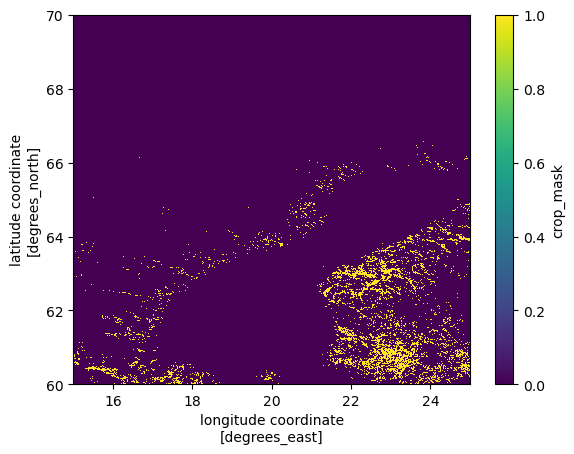

In [33]:
resampled_SM.crop_mask.plot()

**Mask one data array with a condition from another, inserted into one dataset**

Select Soil Moisture (sm) only for rainfed croplands. The result is again a datacube of the same dimensions as the inputs, because we removed the time information from the cropmask before.

In [34]:
SM_crop = resampled_SM.sm.where(
    resampled_SM.crop_mask == 1
)

SM_crop

<xarray.DataArray 'sm' (time: 31, lat: 3600, lon: 3600)> Size: 2GB
dask.array<where, shape=(31, 3600, 3600), dtype=float32, chunksize=(1, 1440, 1080), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 248B 2020-08-01 2020-08-02 ... 2020-08-31
  * lon      (lon) float64 29kB 15.0 15.0 15.01 15.01 ... 24.99 24.99 25.0 25.0
  * lat      (lat) float64 29kB 70.0 70.0 69.99 69.99 ... 60.01 60.01 60.0 60.0
Attributes:
    _CoordinateAxes:      time lat lon
    ancillary_variables:  sm_uncertainty flag t0
    dtype:                float32
    long_name:            Volumetric Soil Moisture
    standard_name:        soil_moisture_content
    units:                m3 m-3
    valid_range:          [0.0, 1.0]

**Visualise result:** sm only on rainfed cropland

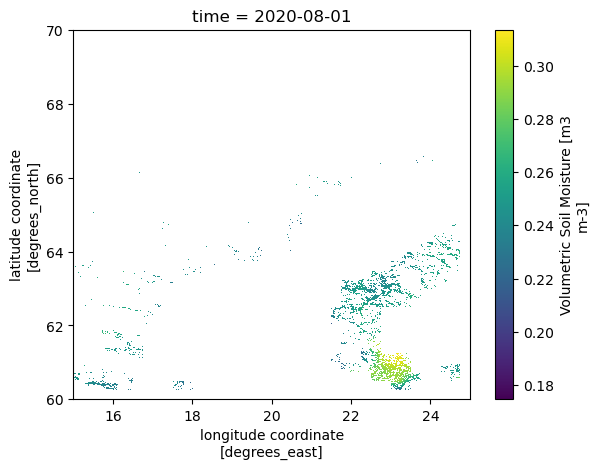

In [35]:
SM_crop.isel(time=0).plot()

The histogram of the sm variable on rainfed croplands:

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00,
        4.0000e+00, 0.0000e+00, 1.0000e+01, 1.7000e+01, 2.5000e+01,
        3.0000e+01, 2.1000e+01, 8.2000e+01, 2.0000e+02, 2.7700e+02,
        4.1500e+02, 5.9700e+02, 5.1100e+02, 9.4800e+02, 1.2230e+03,
        1.2290e+03, 1.3000e+03, 1.2380e+03, 1.9540e+03, 4.3730e+03,
        3.7250e+03, 5.9280e+03, 6.6450e+03, 7.2750e+03, 8.0110e+03,
        8.6910e+03, 9.9490e+03, 1.0385e+04, 1.0353e+04, 1.0969e+04,
        1.0769e+04, 8.9880e+03, 8.6950e+03, 9.2770e+03, 8.6980e+03,
        7.1390e+03, 4.7680e+03, 2.8230e+03, 1.0370e+03, 9.5100e+02,
        9.8600e+02, 9.1500e+02, 7.7800e+02, 6.8000e+02, 7.4100e+02,
        7.4200e+02, 7.6600e+02, 7.8800e+02, 8.91

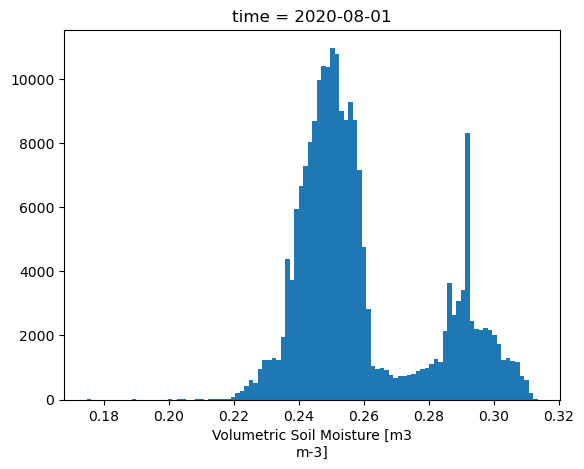

In [36]:
SM_crop.isel(time=0).plot.hist(bins=100)

For comparison, we also visualise the full soil moisture product, without masking condition.

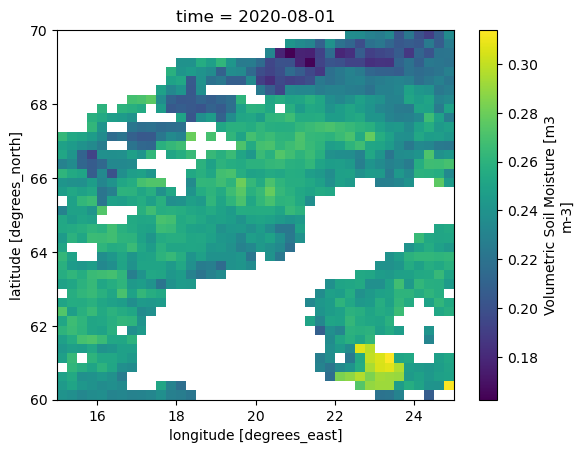

In [37]:
SM.sm.isel(time=0).plot()